# Tensor Decomposition in Python

This notebook gives a quick introduction to Tensor decomposition. However, the main purpose of this notebook is to focus on the implementation of tensor decomposition in Python. In line with these objectives, we will implement tensor decomposition using two libraries available in Python ([TensorLy](http://tensorly.org/stable/index.html) and [tensortools](https://tensortools-docs.readthedocs.io/en/latest/)) and a simple implementation of Tensor Decomposition with Numpy (via alternating optimization). Furthermore, the result of these three approaches are compared in terms of reconstruction error and execution time.

## Content
1. **Tensor Decomposition**
2. **Implementation**
    - TensorLy
    - tensortools
    - Numpy
3. **Results and Comparison**

---

## Tensor Decomposition

Let's simply start by defining each term in the title.

**Tensor**: A tensor is a **multidimensional array**. Also known as **d-way array**, in which "d" stands for "dimensions". Hence, pretty much all of the geometrical data structures we work with are tensors. Up until $d=2$, these tensors have specific names:
- zero-way tensor: **scalar**
- one-way tensor: **vector**
- two-way tensor: **matrix**

One thing to keep in mind, that might be helpful to know for the following sections, is that as the dimensions of the data structure increases we need more values to locate a single element of our data structure. For instance, we can locate any element of a matrix using two values $(i, j)$ and any element of a tensor via three values $(i, j, k)$. Here is a visual representation (up until three-way tensors)

<center>
    <img src="https://raw.githubusercontent.com/mohammadbashiri/tensor-decomposition-in-python/master/figures/d-way.png" alt="d-way" width="500" align="center"/>   
</center>

**Decomposition**: Decomposition is a process of breaking up into constituent elements. In mathematical analysis, it means factorization of a d-way tensor. In systems science, it consists of finding an optimal partition of a system in terms of its subsystems. In general, decompositions are motivated by a need to obtain a much simpler body of constituents that can best represent a given system (or data) [[1]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2735056/pdf/nihms39318.pdf).

**Tensor Decomposition**: Data can be organized as a d-way tensor. Consequently, the decoposition of such data is called a d-way (tensor) decomposition.

### Matrix Decomposition (aka Two-way Decomposition)

Before diving into three-way decomposition, let's quickly refresh ourselves with some of the two-way decompositions (i.e., matrix decomposition). Approaches to two-way decomposition are well established, and include Principal Component Analysis (PCA), Independent Component Analysis (ICA), Nonnegative Matrix Factorization (NMF) and Sparse Component Analysis (SCA). These techniques have become standard tools for e.g., blind source separation (BSS), feature extraction, or classification [[2]](https://ieeexplore.ieee.org/abstract/document/7038247). Here is the general idea: Given $X \in \mathbb{R}^{I \times J}$, we would like to have a model $M$ which approximates $X$ via $\textbf{a} \in \mathbb{R}^I $ and $\textbf{b} \in \mathbb{R}^J$, such that:

$$ X \approx M = \sum_{r=1}^{R} a_r \cdot b_r^{T} = a_r \circ b_r = A \cdot B^T $$

$$ X \in \mathbb{R}^{I \times J}, \textbf{a} \in \mathbb{R}^I, \textbf{b} \in \mathbb{R}^J$$

Such decomposition is known as *Factor Analysis*. The formulation above suffers from a problem called the **Rotation Problem**. That is, we can insert any nonsingular rotation matrix, $Z$, in the formulation above , and still end up with the same approximation of $X$ (given that columns of Z have an amplitude of 1).

<center>
    <img src="https://raw.githubusercontent.com/mohammadbashiri/tensor-decomposition-in-python/master/figures/matrix-decomposition.png" alt="matrix-decomposition" width="800" align="center"/>
</center>

Such decomposition is known as *Factor Analysis*. The formulation above suffers from a problem called the **Rotation Problem**. That is, we can insert any nonsingular rotation matrix, $Z$, in the formulation above , and still end up with the same approximation of $X$ (given that columns of Z have an amplitude of 1).

$$ X \approx M = \sum_{r=1}^{R} a_r \circ z_r^T \circ z_r^{-1} \circ b_r^{T} = A \cdot Z^T \cdot Z^{-1} \cdot B^T $$

Hence, if the above formulation is unconstrained, it results in infinitely many combinations of $A$ and $B$. Standard matrix factorizations in linear algebra, such as the QR-factorization, Eigenvalue Decomposition (EVD), and Singular Value Decomposition (SVD), are only special cases of the above formulation, and owe their uniqueness to hard and restrictive constraints such as triangularity and orthogonality. [[2]](fhttps://ieeexplore.ieee.org/abstract/document/7038247)

### Three-way Tensor Decomposition

Three-way decomposition is merely the extension of the two-way decomposition. However, although in the two-way case explicit constraints must be imposed on the problem to result in a unique solution, the high dimensionality of the tensor format comes with blessings — these include possibilities to obtain compact representations, uniqueness of decompositions, flexibility in the choice of constraints, and generality of components that can be identified [[2]](https://ieeexplore.ieee.org/abstract/document/7038247). In case of three-way decomposition, we have a three-way tensor and we would like to have a model $M$ which approximates $X \in \mathbb{R}^{I \times J \times K}$, via $\textbf{a} \in \mathbb{R}^I $, $\textbf{b} \in \mathbb{R}^J$, and $\textbf{c} \in \mathbb{R}^K$ such that:

$$ X \approx M = \sum_{r=1}^{R} a_r \circ b_r \circ c_r$$

$$X \in \mathbb{R}^{I \times J \times K}, \textbf{a} \in \mathbb{R}^I, \textbf{b} \in \mathbb{R}^J, \textbf{c} \in \mathbb{R}^K$$

Where R is the new (reduced) dimension of our data, often referred to as **rank**. As a result of such decomposition, we will have three Matrices $A \in \mathbb{R}^{I \times R}$, $B \in \mathbb{R}^{J \times R}$, and $C \in \mathbb{R}^{K \times R}$. This operation is simply the summation of outer product of each column of $A$, $B$, and $C$ where the column index is specified by $r$, as depicted below:

<center>
    <img src="https://raw.githubusercontent.com/mohammadbashiri/tensor-decomposition-in-python/master/figures/tensor-decomposition.png" alt="tensor-decomposition" width="800" align="center"/>
</center>

## How to find A, B, and C?

In this section we will focus on the implementation of three-way tensor decomposition using two Python libraries: [TensorLy](http://tensorly.org/stable/index.html) and [tensortools](https://tensortools-docs.readthedocs.io/en/latest/). Furthermore, we will also implement a very simple three-way tensor decomposer using Numpy and an alternating optimization algorithm. The example used here is inspired by Figure 2 (as depicted below) of [this paper](https://doi.org/10.1016/j.neuron.2018.05.015) which introduced tensor decomposition, mainly to the neuroscience research.

<center>
    <p float="left">
      <img src="https://raw.githubusercontent.com/mohammadbashiri/tensor-decomposition-in-python/master/figures/model.png" style="width:43%" />
      <img src="https://raw.githubusercontent.com/mohammadbashiri/tensor-decomposition-in-python/master/figures/neuron-time.png" style="width:56%" /> 
    </p>
</center>

Let's start by importing the libraries and functions that we are going to need:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import FactorAnalysis, PCA
import tensortools as tt
from tensortools.operations import unfold as tt_unfold, khatri_rao
import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac

from utils import *

Using numpy backend.


### Our Tensor

Let's load the data - I have already created the data, shown in previous figure.

In [2]:
time_factor = np.load("data/time_factor.npy")
neuron_factor = np.load("data/neuron_factor.npy")
trial_factor = np.load("data/trial_factor.npy")
latent = np.load("data/latent.npy")
observed = np.load("data/observed.npy")

Below we can see how the amplitude of each one of the latent factors (neurons) change over time and trials:

<center>
    <p float="left">
      <img src="https://raw.githubusercontent.com/mohammadbashiri/tensor-decomposition-in-python/master/figures/factor0.png" style="width:32%" />
      <img src="https://raw.githubusercontent.com/mohammadbashiri/tensor-decomposition-in-python/master/figures/factor1.png" style="width:32%" /> 
      <img src="https://raw.githubusercontent.com/mohammadbashiri/tensor-decomposition-in-python/master/figures/factor2.png" style="width:32%" /> 
    </p>
</center>

And let's save the actual $A$, $B$, and $C$ matrices for later comparison.

In [3]:
factors_actual = (normalize(time_factor), normalize(neuron_factor), normalize(trial_factor))

## Implementation of Tensor Decomposition (using the libraries)

Concerning the libraries, the implementation is very similar: Simply call the decomposition function and pass the tensor and the rank (number of factors). In **TensorLy**, the function is called `parafac` which implements Canocical Polyadic (CP) decomposition via alternating least squares (ALS). There is a history of how this name came about, but it is also known as Canonical Decomposition (CANDECOMP), as well as Parallel Factorization (PARAFAC). In **tensortools** it is called `cp_als` which implements the same thing.

Below is the a minimal code to implement CP tensor decomposition in both libraries:
- Specify the tensor, and the rank (number of factors)
- Use the function to decompose the tensor
- Furthermore, we can reconstruct the estimate $M$ using the `reconstruct` function provided in the script.

In [4]:
# Specify the tensor and the rank
X, rank = observed, 3

In [5]:
# Perform CP decompositon using TensorLy
factors_tl = parafac(X, rank=rank)

# Perform CP decomposition using tensortools
U = tt.cp_als(X, rank=rank, verbose=False)
factors_tt = U.factors.factors

In [6]:
# Reconstruct M, with the result of each library
M_tl = reconstruct(factors_tl)
M_tt = reconstruct(factors_tt)

In [7]:
# Compute the reconstruction error
rec_error_tl = np.mean((X-M_tl)**2)
rec_error_tt = np.mean((X-M_tt)**2)

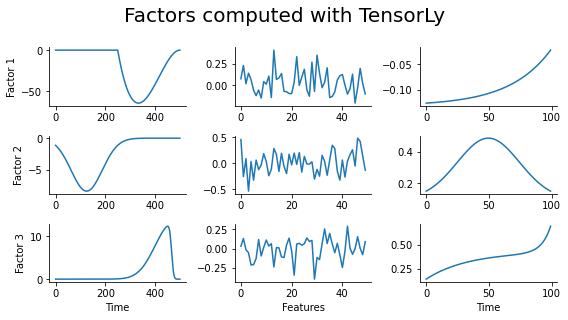

In [8]:
# plot the decomposed factors from TensorLy
plot_factors(factors_tl, d=3)
plt.suptitle("Factors computed with TensorLy", y=1.1, fontsize=20);

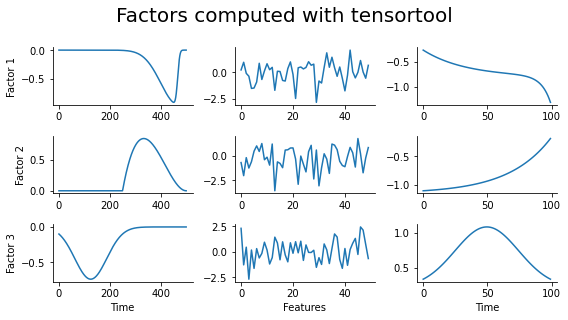

In [9]:
# plot the decomposed factors from TensorLy
plot_factors(factors_tt, d=3)
plt.suptitle("Factors computed with tensortool", y=1.1, fontsize=20);

### Tensor Decomposition using Numpy

#### The optimization problem

Ultimately we would like to minimize the difference between $X$ (ground truth) and $M$ (model estimate, which is the approximation of $X$). Hence, we can formulate our loss function as the Squared Error between $X$ and $M$:


$$\underset{A, B, C}{\operatorname{min}} \sum_{i, j, k} (x_{ijk} - m_{ijk})^2 = \underset{A, B, C}{\operatorname{min}} \sum_{i, j, k} (x_{ijk} - \sum_{r=1}^{R} a_{ir} b_{jr} c_{kr})^2$$

$M$ is being computed using three Matrices $A$, $B$ and $C$, all of which we do not know. One way to find them is to optimize for one, while fixing the other two. Once we optimize one, we use it as a fixed matrix while optimizing for another. And we alternate between optimizing $A$, $B$ and $C$ until convergence, or a stoppage criterion. Hence, we are going to write our loss function for each Matrix, as follows:

$$\underset{\color{red}{A}}{\operatorname{min}} \sum_{i, j, k} (x_{ijk} - \sum_{r=1}^{R} \color{red}{a_{ir}} b_{jr} c_{kr})^2 = 
\underset{\color{red}{A}}{\operatorname{min}} || X_{(0)} - \color{red}{A}(B \odot C)^T ||_F^2$$

$$\underset{\color{red}{B}}{\operatorname{min}} \sum_{i, j, k} (x_{ijk} - \sum_{r=1}^{R} a_{ir} \color{red}{b_{jr}} c_{kr})^2 = 
\underset{\color{red}{B}}{\operatorname{min}} || X_{(1)} - \color{red}{B}(A \odot C)^T ||_F^2$$

$$\underset{\color{red}{C}}{\operatorname{min}} \sum_{i, j, k} (x_{ijk} - \sum_{r=1}^{R} a_{ir} b_{jr} \color{red}{c_{kr}})^2 = 
\underset{\color{red}{C}}{\operatorname{min}} || X_{(2)} - \color{red}{C}(A \odot B)^T ||_F^2$$

Where $X_{(0)}$ denotes the mode-0 unfolding of tensor X into a matrix, and so on. and $(B \odot C)^T$ denotes the *Khatri-Rao* product which combines B and C into a single matrix. In general, this is a non-convex problem; however, when we optimize for one matrix at the time, that is a convex problem. If you'd like to know more about unfolding a tensor into a matrix, click on this [link](http://jeankossaifi.com/blog/unfolding.html).

In [10]:
def decompose_three_way(tensor, rank, max_iter=501, verbose=False):

    # a = np.random.random((rank, tensor.shape[0]))
    b = np.random.random((rank, tensor.shape[1]))
    c = np.random.random((rank, tensor.shape[2]))

    for epoch in range(max_iter):
        # optimize a
        input_a = khatri_rao([b.T, c.T])
        target_a = tl.unfold(tensor, mode=0).T
        a = np.linalg.solve(input_a.T.dot(input_a), input_a.T.dot(target_a))

        # optimize b
        input_b = khatri_rao([a.T, c.T])
        target_b = tl.unfold(tensor, mode=1).T
        b = np.linalg.solve(input_b.T.dot(input_b), input_b.T.dot(target_b))
                            
        # optimize c
        input_c = khatri_rao([a.T, b.T])
        target_c = tl.unfold(tensor, mode=2).T
        c = np.linalg.solve(input_c.T.dot(input_c), input_c.T.dot(target_c))

        if verbose and epoch % int(max_iter * .2) == 0:
            res_a = np.square(input_a.dot(a) - target_a)
            res_b = np.square(input_b.dot(b) - target_b)
            res_c = np.square(input_c.dot(c) - target_c)
            print("Epoch:", epoch, "| Loss (C):", res_a.mean(), "| Loss (B):", res_b.mean(), "| Loss (C):", res_c.mean())
        
    return a.T, b.T, c.T

The rest is very similar to how we used the other two libraries previously

In [11]:
factors_np = decompose_three_way(X, rank, verbose=False)

In [12]:
a, b, c = factors_np
factors = (normalize(a), normalize(b), normalize(c))

Compute M, as well as the reconstruction Error

In [13]:
M_np = reconstruct(factors_np)
rec_error_np = np.mean((X-M_np)**2)

A comparison (of a single trial) between the three approaches in estimating $X$.

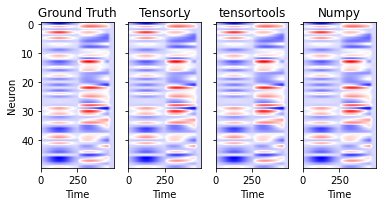

In [14]:
fig, axes = plt.subplots(1, 4, sharey=True)
tensors = [X, M_tl, M_tt, M_np]
titles = ["Ground Truth", "TensorLy", "tensortools", "Numpy"]
trial_num = 50

for title, tensor, ax in zip(titles, tensors, axes):
    ax.imshow(tensor[:, :, trial_num].T, cmap='bwr', aspect=20)
    ax.set_xlabel("Time")
    ax.set_title(title)
axes[0].set_ylabel("Neuron");

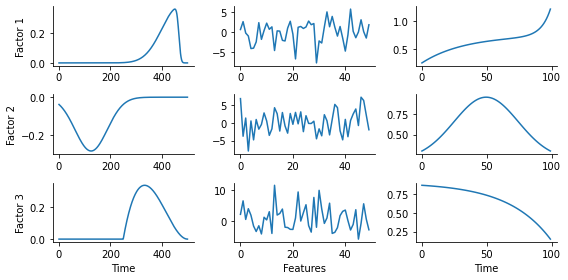

In [15]:
plot_factors(factors_np, d=3)

It turns out that sometimes the factors can be inverted. However, if one of them is inverted, surely another one should also be inverted (-ve time -ve = +ve). Hence, depending on the expectations and interpretation that you have from the result, you might need to invert some of the factors. Culomns correspond to factors, and rows refer to decomposed matrix ($A$, $B$, and $C$).

In [16]:
# a[:, 1] = a[:, 1] * -1
# b[:, 1] = b[:, 1] * -1
# c[:, 2] = c[:, 2] * -1

We are gonna normalize the factors, so that we can compare them with the ground truth (remember that we normalize the true factors once we imported the data)

In [17]:
factors = (normalize(a), normalize(b), normalize(c))

The factors might also be replaced. Hence, in the plotting function below, I have an ordering input where you can choose how to order the factors. So here is what we do:
1. order the factors as they are: `factors_ind=[0, 1, 2]`
2. depending on how they are appearing with respect to the ground truth you can now change the order. For instace: `factors_ind=[1, 0, 2]`

However, in the real application we do not knnow the ground truth. So this part is merely for convinient visualization and assessing the method.

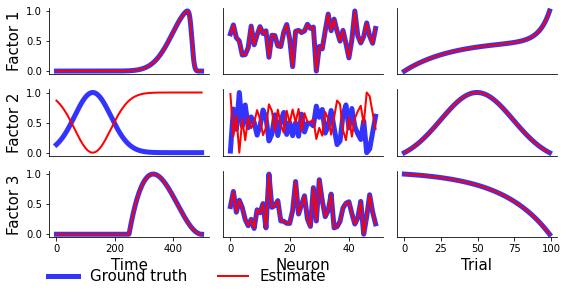

In [19]:
fig, axes = plt.subplots(rank, 3, figsize=(8, int(rank * 1.2 + 1)))
compare_factors(factors, factors_actual, factors_ind=[0, 1, 2], fig=fig);

### Comparing the three approaches

#### Reconstruction Error and Time

In [20]:
import timeit

In [21]:
iter_num = 50
times = {'tl': [], 'tt': [], 'np': []}
rec_errors = {'tl': [], 'tt': [], 'np': []}

# TensorLy
for i in range(iter_num):
    start_time = timeit.default_timer()
    factors_tl = parafac(X, rank=rank, tol=0, n_iter_max=200)
    end_time = timeit.default_timer() - start_time
    times['tl'].append(end_time)
    M_tl = reconstruct(factors_tl)
    rec_error_tl = np.mean((X-M_tl)**2)
    rec_errors['tl'].append(rec_error_tl)
    print("TensorLy | Iteration: {} / {} | time take: {} sec".format(i+1, iter_num, end_time), end="\r")

# tensortools
for i in range(iter_num):
    start_time = timeit.default_timer()
    U = tt.cp_als(X, rank=rank, tol=0, max_iter=200, verbose=False)
    factors_tt = U.factors.factors
    end_time = timeit.default_timer() - start_time
    times['tt'].append(end_time)
    M_tt = reconstruct(factors_tt)
    rec_error_tt = np.mean((X-M_tt)**2)
    rec_errors['tt'].append(rec_error_tt)
    print("tensortools | Iteration: {} / {} | time take: {} sec".format(i+1, iter_num, end_time), end="\r")

# Numpy
for i in range(iter_num):
    start_time = timeit.default_timer()
    factors_np = decompose_three_way(X, rank, max_iter=200, verbose=False)
    end_time = timeit.default_timer() - start_time
    times['np'].append(end_time)
    M_np = reconstruct(factors_np)
    rec_error_np = np.mean((X-M_np)**2)
    rec_errors['np'].append(rec_error_np)
    print("Numpy | Iteration: {} / {} | time take: {} sec".format(i+1, iter_num, end_time),end="\r")

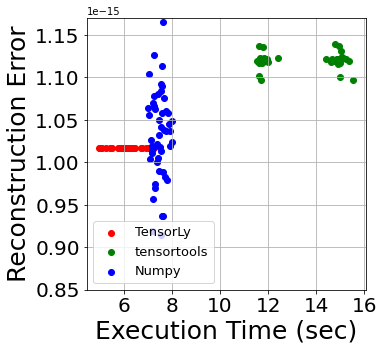

In [22]:
plt.figure(figsize=(5, 5)) #, dpi=200)
factor = 1e15
plt.scatter(np.array(times['tl']), np.array(rec_errors['tl']), c='red', label="TensorLy")
plt.scatter(np.array(times['tt']), np.array(rec_errors['tt']), c='green', label="tensortools")
plt.scatter(np.array(times['np']), np.array(rec_errors['np']), c='b', label="Numpy")
plt.xlabel("Execution Time (sec)", fontsize=25)
plt.ylabel("Reconstruction Error", fontsize=25)
plt.ylim(0.85 * 1e-15, 1.17 * 1e-15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="lower left", fontsize=13);
plt.grid()

# plt.savefig("metric-1.png", transparent=True, bbox_inches='tight')

---

## Reference

- Tuncer, Yalcin, Murat M. Tanik, and David B. Allison. "An overview of statistical decomposition techniques applied to complex systems." Computational statistics & data analysis 52.5 (2008): 2292–2310.
- Cichocki, Andrzej, et al. "Tensor decompositions for signal processing applications: From two-way to multiway component analysis." IEEE Signal Processing Magazine 32.2 (2015): 145–163.
- Williams, Alex H., et al. "Unsupervised Discovery of Demixed, Low-Dimensional Neural Dynamics across Multiple Timescales through Tensor Component Analysis." Neuron (2018).
- [Talk](https://www.youtube.com/watch?v=L8uT6hgMt00&t=1302s) by Tamara Kolda
- Tutorial by Alex Williams: [part 1](https://www.youtube.com/watch?v=hmmnRF66hOA), [part 2](https://www.youtube.com/watch?v=O-YTsSuEFiM&t=5s)